### Prepare data

In [1]:
library(sqldf)
library(ggplot2)

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite


Download csv data from github

In [2]:
airq25<-read.csv("https://raw.githubusercontent.com/Maplub/AirQualityData/master/PM2-5_2018_daily.csv")
airq10<-read.csv("https://raw.githubusercontent.com/Maplub/AirQualityData/master/PM10_2018_daily.csv")

Change column names

In [3]:
colnames(airq25)<-c("id","da","pm25")
colnames(airq10)<-c("id","da","pm10")

Join PM2.5 and PM10 Table

In [4]:
airq<-sqldf("select a.id,a.da,a.pm25,b.pm10 from airq25 a, airq10 b where a.id=b.id and a.da=b.da")

In [5]:
head(airq)

id,da,pm25,pm10
CU-S0005,2018-02-07,45.86923,56.26923
CU-S0005,2018-02-07,45.86923,56.30913
CU-S0006,2018-02-07,46.12795,57.23636
CU-S0006,2018-02-07,46.12795,58.32144
CU-S0009,2018-02-07,46.32250,57.90004
CU-S0009,2018-02-07,46.32250,59.60125


There is one SOO94 (O not 0) row. Just remove it

In [6]:
airq<-airq[!grepl("CU-SOO94", airq$id),]

Read sensorlist from file. Set to UTF-8.

In [7]:
sensorlist<-read.csv("sensorlist.csv",encoding="UTF-8", stringsAsFactors=FALSE)
sensorlist[]     <- lapply(sensorlist, as.character)
Encoding(sensorlist$tambol)

[1] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[10] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[19] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[28] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[37] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[46] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[55] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[64] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[73] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[82] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[91] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"

Change da column to Date format

In [8]:
airq$date<-as.Date(airq$da,"%Y-%m-%d")

To use code from the previous year, separate day, month, and year.

In [9]:
airq$d<-as.numeric(format(airq$date,'%d'))
airq$m<-as.numeric(format(airq$date,'%m'))
airq$y<-as.numeric(format(airq$date,'%Y'))

Calculate day of year

In [10]:
airq$doy <- strftime(airq$date, format = "%j")
airq$doy<-as.numeric(airq$doy)

Remove NA rows and zero rows.

In [69]:
library(dplyr)
airq <- filter(airq, pm25 > 0, pm10 > 0)
airq<-na.omit(airq)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Give the label to month, save it as monthf

In [12]:
airq$monthf<-factor(airq$m,levels=as.character(1:12),labels=c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"),ordered=TRUE)

Get week of year from date

In [13]:
airq$woy<-as.numeric(format(airq$date,"%W"))

Below is the code from the previous year. I forget what it is.

In [14]:
library(plyr)
airq<-ddply(airq,.(m),transform,monthweek=1+woy-min(woy))

In [15]:
airq$dow<-as.POSIXlt(airq$date)$wday

In [16]:
airq$dowf<-factor(airq$dow,levels=rev(0:6),labels=rev(c("Sun","Mon","Tue","Wed","Thu","Fri","Sat")),ordered=TRUE)

In [70]:
maxpm25<-max(airq$pm25)
airq$pm25f<-cut(airq$pm25,c(0, 15, 40, 65, 150,maxpm25))

In [71]:
maxpm10<-max(airq$pm10)
airq$pm10f<-cut(airq$pm10,c(0,50,100,200,300,maxpm10))

In [72]:
sqldf('select distinct(pm10f) from airq')

pm10f
"(50,100]"
"(0,50]"
"(100,200]"
"(200,300]"
"(300,1.26e+03]"


### And finally! I can plot it.

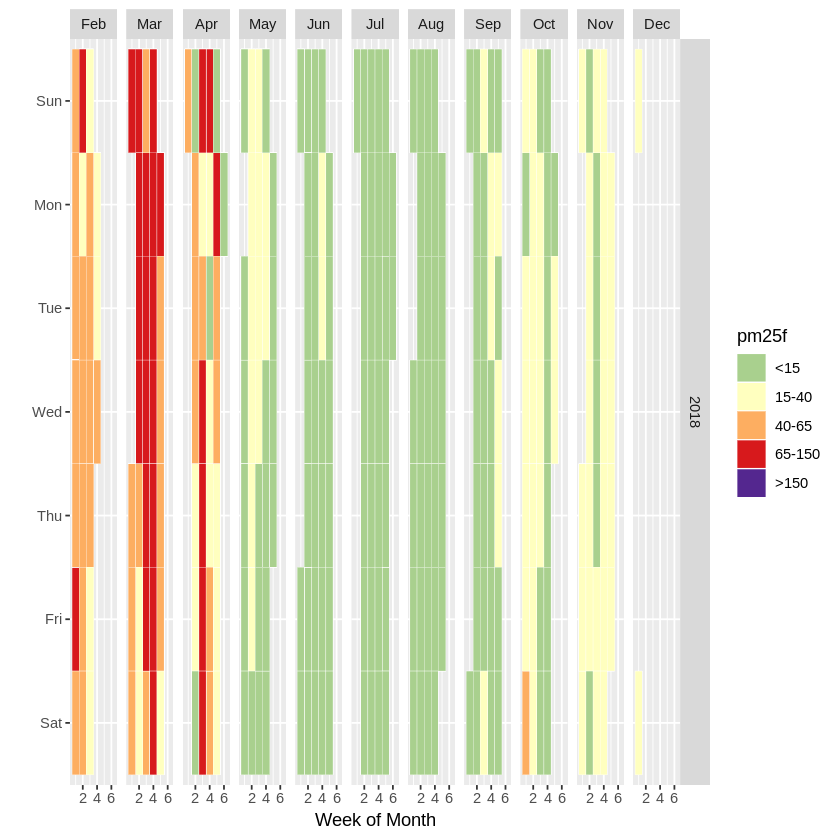

In [73]:
ggplot(airq, aes(monthweek,dowf)) + geom_tile(aes(fill = pm25f),colour = "white") + scale_fill_manual(values=c("#A9D08E","#ffffbf","#fdae61","#d7191c","#54278f"),labels = c("<15","15-40","40-65","65-150",">150"))+ facet_grid(y~monthf) + xlab("Week of Month") + ylab("")

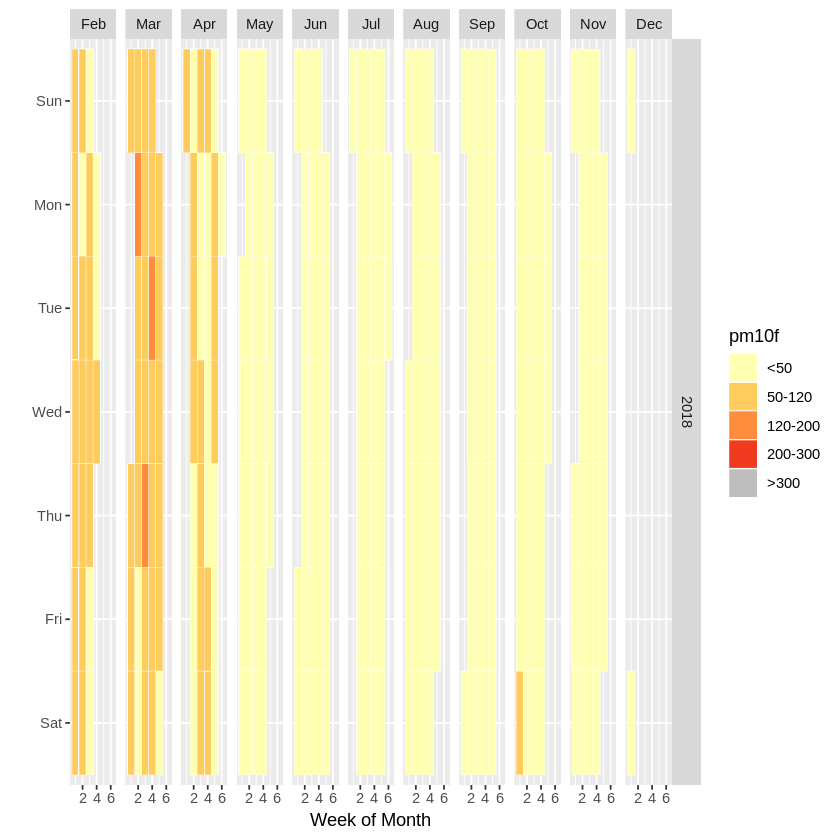

In [74]:
ggplot(airq, aes(monthweek,dowf)) + geom_tile(aes(fill = pm10f),colour = "white") + scale_fill_manual(values=c("#ffffb2","#fecc5c","#fd8d3c","#f03b20","grey"),labels = c("<50","50-120","120-200","200-300",">300"))+ facet_grid(y~monthf) + xlab("Week of Month") + ylab("")

Bind it with sensorlist to get Tambol name

In [75]:
airq<-sqldf("select a.*,s.tambol,s.amphoe from airq a, sensorlist s where a.id=s.sensorid")

In [76]:
cc2.5 <- scale_fill_manual(guide = guide_legend(title = "PM2.5"),values=c("#A9D08E","#ffffbf","#fdae61","#d7191c","#54278f"),labels = c("less than 15","15-40","40-65","65-150","more than 150"))
cc10 <- scale_fill_manual(guide = guide_legend(title = "PM10"),values=c("#A9D08E","#ffffbf","#fdae61","#d7191c","#54278f"),labels = c("less than 50","50-100","100-200","200-300","more than 300"))

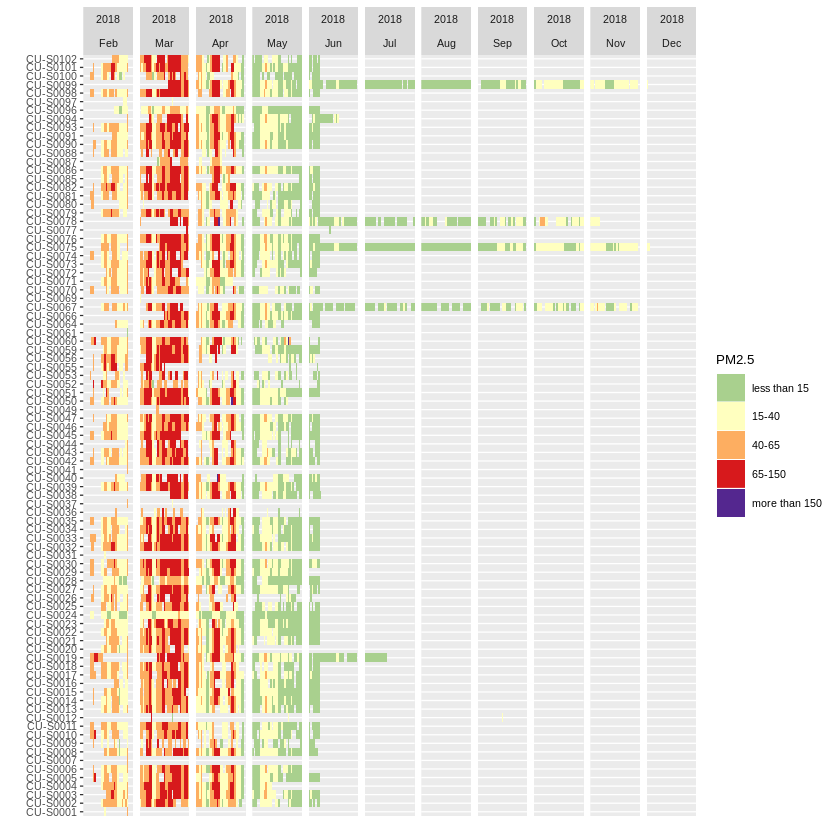

In [77]:
p<-ggplot(airq, aes(d,id)) +geom_tile(aes(fill = pm25f))+facet_grid(.~ y+monthf)+ cc2.5
base_size<-8
p +theme_grey(base_size = base_size) + labs(x = "",y = "") + scale_x_discrete(expand = c(0, 0)) +
scale_y_discrete(expand = c(0, 0))

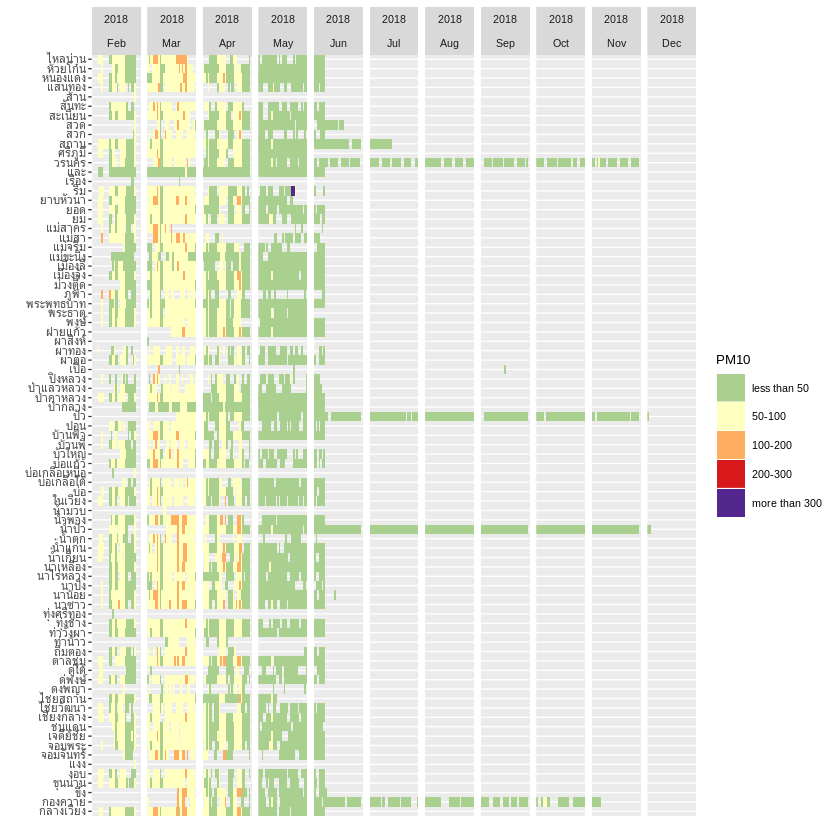

In [78]:
p<-ggplot(airq, aes(d,tambol)) +geom_tile(aes(fill = pm10f))+facet_grid(.~ y+monthf)+ cc10
base_size<-8
p +theme_grey(base_size = base_size) + labs(x = "",y = "") + scale_x_discrete(expand = c(0, 0)) +
scale_y_discrete(expand = c(0, 0))

In [85]:
subairq<-sqldf('select * from airq where m=4')

In [88]:
plot<-ggplot(subairq, aes(d,reorder(id, pm10, mean, order=TRUE))) +geom_tile(aes(fill = pm10f),colour="white")+theme (axis.text.y = element_text(size=6))+ cc10

Saving 6.67 x 6.67 in image


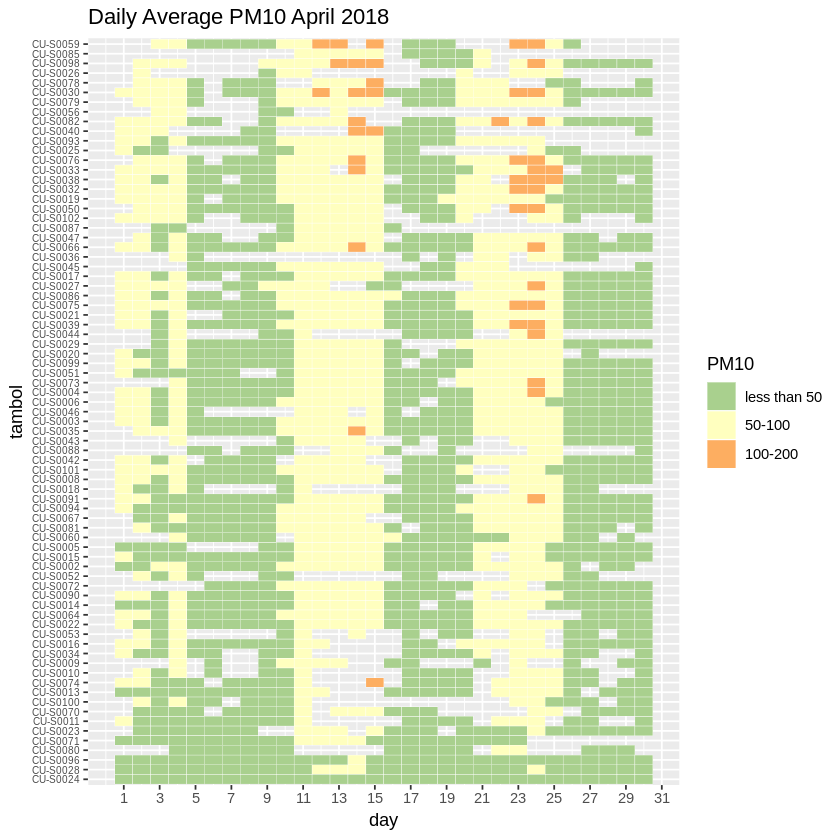

In [89]:
plot+labs(x = "day", y="tambol")+ggtitle("Daily Average PM10 April 2018")+scale_x_continuous(breaks=c(1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31))
ggsave("pm10april18.png")